In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.stats
from collections import Counter
import os.path
import sys
from functools import partial

In [2]:
def scale(data):
    num_rows, num_cols = np.array(data).shape
    means = [np.mean(get_column(data, j)) for j in range(num_cols)]
    stdevs = [np.std(get_column(data, j)) for j in range(num_cols)]
    return means, stdevs

In [3]:
def rescale(data):
    """
    rescales the input data so that each column has mean 0 and standard deviation 1
    leaves alone columns with no deviation
    """
    means, stdevs = scale(data)
    
    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data[i][j] - means[j]) / stdevs[j]
        else:
            return data[i][j]

    num_rows, num_cols = np.array(data).shape
    return make_matrix(num_rows, num_cols, rescaled)

In [4]:
def	make_matrix(num_rows,	num_cols,	entry_fn):
				"""returns	a	num_rows	x	num_cols	matrix
				whose	(i,j)th	entry	is	entry_fn(i,	j)"""
				return	[[entry_fn(i,	j)													#	given	i,	create	a	list
													for	j	in	range(num_cols)]		#			[entry_fn(i,	0),	...	]
												for	i	in	range(num_rows)]			#	create	one	list	for	each	i

In [5]:
def	de_mean_matrix(A):
				"""returns	the	result	of	subtracting	from	every	value	in	A	the	mean
				value	of	its	column.	the	resulting	matrix	has	mean	0	in	every	column"""
				nr,	nc	=	np.array(A).shape
				column_means,	_	=	scale(A)
				return	make_matrix(nr,	nc,	lambda	i,	j:	A[i][j]	-	column_means[j])

In [6]:
def	get_row(A,	i):
	return	A[i]													#	A[i]	is	already	the	ith	row
def	get_column(A,	j):
				return	[A_i[j]										#	jth	element	of	row	A_i
												for	A_i	in	A]			#	for	each	row	A_i

In [7]:
n = 100
A = [[x,y] for x,y in zip(np.random.randn(n) * 10, np.random.randn(n) * 3)]

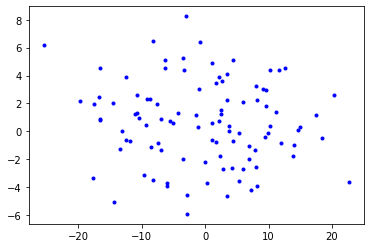

In [8]:
plt.scatter(get_column(A,0), get_column(A,1), marker='.', color='blue')
plt.show()

In [9]:
theta = - math.pi / 7
rotate = [[math.cos(theta), -math.sin(theta)],
          [math.sin(theta), math.cos(theta)]]

In [10]:
def	matrix_product_entry(A,	B,	i,	j):
		return	np.dot(get_row(A,	i),	get_column(B,	j))
    
def	matrix_multiply(A,B):
	n1,	k1	= np.array(A).shape
	n2,	k2	= np.array(B).shape
	if	k1	!=	n2:
		raise	ArithmeticError("incompatible	shapes!")
	return	make_matrix(n1,	k2,	partial(matrix_product_entry,	A,	B))

In [11]:
B = matrix_multiply(A, rotate)

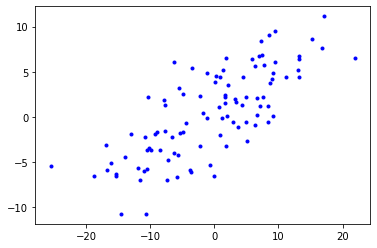

In [12]:
plt.scatter(get_column(B,0), get_column(B,1), marker='.', color='blue')
plt.show()

In [13]:
def	vector_add(v,	w):
				"""adds	corresponding	elements"""
				return	[v_i	+	w_i
												for	v_i,	w_i	in	zip(v,	w)]
        
def	vector_sum(vectors):
				"""sums	all	corresponding	elements"""
				result	=	vectors																									#	start	with	the	first	vector
				for	vector	in	vectors:																		#	then	loop	over	the	others
								result	=	vector_add(result,vector)					#	and	add	them	to	the	result
				return	result

In [14]:
def	negate(f):
				"""return	a	function	that	for	any	input	x	returns	-f(x)"""
				return	lambda	*args,	**kwargs:	-f(*args,	**kwargs)
def	negate_all(f):
				"""the	same	when	f	returns	a	list	of	numbers"""
				return	lambda	*args,	**kwargs:	[-y	for	y	in	f(*args,	**kwargs)]

In [15]:
def	safe(f):
				"""return	a	new	function	that's	the	same	as	f,
				except	that	it	outputs	infinity	whenever	f	produces	an	error"""
				def	safe_f(*args,	**kwargs):
								try:
												return	f(*args,	**kwargs)
								except:
												return	float('inf')									#	this	means	"infinity"	in	Python
				return	safe_f

In [16]:
def	step(v,	direction,	step_size):
				"""move	step_size	in	the	direction	from	v"""
				return	[v_i	+	step_size	*	direction_i
												for	v_i,	direction_i	in	zip(v,	direction)]

In [17]:
def	sum_of_squares(v):
				"""v_1	*	v_1	+	...	+	v_n	*	v_n"""
				return	np.dot(v,	v)

In [18]:
def	magnitude(v):
				return	np.sqrt(sum_of_squares(v))			#	math.sqrt	is	square	root	function

In [19]:
def	direction(w):
				mag	=	magnitude(w)
				return	[w_i	/	mag	for	w_i	in	w]

In [20]:
def	directional_variance_i(x_i,	w):
				"""the	variance	of	the	row	x_i	in	the	direction	determined	by	w"""
				return	np.dot(x_i,	direction(w))	**	2
def	directional_variance(X,	w):
				"""the	variance	of	the	data	in	the	direction	determined	w"""
				return	np.sum(directional_variance_i(x_i,	w)
															for	x_i	in	X)

In [21]:
def	directional_variance_gradient_i(x_i,	w):
				"""the	contribution	of	row	x_i	to	the	gradient	of
				the	direction-w	variance"""
				projection_length	=	np.dot(x_i,	direction(w))
				return	[2	*	projection_length	*	x_ij	for	x_ij	in	x_i]
def	directional_variance_gradient(X,	w):
				return	vector_sum(directional_variance_gradient_i(x_i,w)
																						for	x_i	in	X)

In [22]:
def	maximize_batch(target_fn,	gradient_fn,	theta_0,	tolerance=0.000001):
				return	minimize_batch(negate(target_fn), negate_all(gradient_fn), theta_0, tolerance)

In [23]:
def	minimize_batch(target_fn,	gradient_fn,	theta_0,	tolerance=0.000001):
				"""use	gradient	descent	to	find	theta	that	minimizes	target	function"""
				step_sizes	=	[100,	10,	1,	0.1,	0.01,	0.001,	0.0001,	0.00001]
				theta	=	theta_0																											#	set	theta	to	initial	value
				target_fn	=	safe(target_fn)															#	safe	version	of	target_fn
				value	=	target_fn(theta)																		#	value	we're	minimizing
				while	True:
								gradient	=	gradient_fn(theta)
								next_thetas	=	[step(theta,	gradient,	-step_size)
																							for	step_size	in	step_sizes]
								#	choose	the	one	that	minimizes	the	error	function
								next_theta	=	min(next_thetas,	key=target_fn)
								next_value	=	target_fn(next_theta)
								#	stop	if	we're	"converging"
								if	abs(value	-	next_value)	<	tolerance:
												return	theta
								else:
												theta,	value	=	next_theta,	next_value

In [24]:
def	first_principal_component(X):
				guess	=	[1	for	_	in	X[0]]
				unscaled_maximizer	=	maximize_batch(
								partial(directional_variance,	X),											#	is	now	a	function	of	w
								partial(directional_variance_gradient,	X),		#	is	now	a	function	of	w
								guess)
				return	direction(unscaled_maximizer)

In [25]:
pc1 = first_principal_component(B)
pc1

C:\Users\USER\AppData\Local\Temp/ipykernel_24248/1532052973.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return	np.sum(directional_variance_i(x_i,	w)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()